In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pyvisa
import time

In [2]:
resources = pyvisa.ResourceManager()
resources.list_resources()

('USB0::0x1AB1::0x04CE::DS1ZA204619142::INSTR',
 'USB0::0xF4EC::0x1103::SDG1XCAD2R3284::INSTR',
 'ASRL1::INSTR',
 'ASRL3::INSTR')

In [3]:
class SDG1000X(object):
    def __init__(self, resource_name):
        self.rm = pyvisa.ResourceManager()
        self.instr = self.rm.open_resource(resource_name)
        self.instr.write_termination = '\n'
        self.instr.read_termination = '\n'
    
    def query(self, command):
        return self.instr.query(command)
    
    def command(self, command):
        self.instr.write(command)

In [4]:
class RigolDS1054Z(object):
    def __init__(self, resource_name):
        self.rm = pyvisa.ResourceManager()
        self.instr = self.rm.open_resource(resource_name)
        self.instr.read_termination = '\n'
        
    def query(self, command):
        return self.instr.query(command)
    
    def command(self, command):
        self.instr.write(command)
#         val = self.query(f'{command.split(" ")[0]}?')
#         print(f'{command} scope value is {val}')

In [5]:
def setup_scope_y(oscilloscope, channels, couplings, offsets, scales):
    for ch, coupling in zip(channels, couplings):
        oscilloscope.command(f':CHAN{ch}:COUP {coupling}')
    for ch in [1,2,3,4]:
        if ch not in channels:
            oscilloscope.command(f':CHAN{ch}:DISP OFF')
        else:
            oscilloscope.command(f':CHAN{ch}:DISP ON')
    for ch, offset in zip(channels, offsets):
        oscilloscope.command(f':CHAN{ch}:OFFS {offset}')
    for ch, scale in zip(channels, scales):
        oscilloscope.command(f':CHAN{ch}:SCAL {scale}')            
        
def setup_scope_x(oscilloscope, scale, offset):
    oscilloscope.command(f':TIM:MAIN:SCAL {scale}')  
    oscilloscope.command(f':TIM:MAIN:OFFS {offset}')
    
def setup_scope_trigger(oscilloscope, source, coupling, slope, level):
    oscilloscope.command(f':TRIG:COUP {coupling}')
    oscilloscope.command(f':TRIG:EDG:SOUR {source}')  
    oscilloscope.command(f':TRIG:EDG:SLOP {slope}') 
    oscilloscope.command(f':TRIG:EDG:LEV {level}')

In [6]:
def scope_acquire(oscilloscope, channels):
    oscilloscope.command(':WAV:MODE NORM')
    oscilloscope.command(':WAV:FORM ASCII')
        
    data = []
    for channel in channels:
        oscilloscope.command(f':WAV:SOUR CHAN{channel}')
        d = np.array(oscilloscope.query(':WAV:DATA?')[11:].split(','), float)
        data.append(d)
    dt = float(oscilloscope.query('WAV:XINC?'))
    torigin = float(oscilloscope.query('WAV:XOR?'))
    t = np.arange(len(d))*dt + torigin
    data.insert(0, t)
    return np.array(data)

In [7]:
def create_hdf_grp(fname, grp_name, attrs):
    with h5py.File(fname, 'a') as f:
        grp = f.create_group(grp_name)
        if attrs:
            for k,v in attrs.items():
                grp.attrs[k] = v

def create_hdf_subgrp(fname, grp_name, sub_grp_name, attrs):
    with h5py.File(fname, 'a') as f:
        grp = f[grp_name]
        sub_grp = grp.create_group(sub_grp_name)
        if attrs:
            for k,v in attrs.items():
                sub_grp.attrs[k] = v

def create_hdf_ssubgrp(fname, grp_name, sub_grp_name, ssub_grp_name, attrs):
    with h5py.File(fname, 'a') as f:
        grp = f[grp_name]
        sub_grp = grp[sub_grp_name]
        ssub_grp = sub_grp.create_group(ssub_grp_name)
        if attrs:
            for k,v in attrs.items():
                ssub_grp.attrs[k] = v
    
def create_dset(fname, grp_name, sub_grp_name, ssub_grp_name, dset_name, data, cols, units):
    attr_units = dict([(k,v) for k,v in zip(cols, units)])
    dtype = np.dtype([(k, eval(t)) for k,t in zip(cols, types)])
    d = np.array([tuple(d) for d in data], dtype = dtype)
    
    with h5py.File(fname, 'a') as f:
        grp = f[grp_name]
        grp = grp[sub_grp_name]
        grp = grp[ssub_grp_name]
        dset = grp.create_dataset(dset_name, data = d)
        dset.attrs['units'] = str(attr_units)

In [226]:
fname = 'CDCLVC1102_testing.hdf5'
nsamples_per_freq = 100
frequencies = np.array([1,5,10,15,20,25,30])

types = 'float, float, float'.split(',')
units = 's, V, V'.split(',')
units = [u.strip() for u in units]
cols = 'time, CDCLVC1102_output, SDG_1032X_output'.split(',')
cols = [c.strip() for c in cols]


osc = RigolDS1054Z('USB0::0x1AB1::0x04CE::DS1ZA204619142::INSTR')

setup_scope_y(osc, [1,2], ['DC']*2, [-0.6, -1.6], [0.2, 0.5])
setup_scope_x(osc, 10e-9, 0)
setup_scope_trigger(osc, 'CHAN2', 'DC', 'POS', 1.4)

grp_name = 'REV1 Board Tests'
create_hdf_grp(fname, grp_name, None)
sub_grp_name = '50Ohm termination'
create_hdf_subgrp(fname, grp_name, sub_grp_name, {'description': '50Ohm termination at scope'})

sdg = SDG1000X('USB0::0xF4EC::0x1103::SDG1XCAD2R3284::INSTR')
osc = RigolDS1054Z('USB0::0x1AB1::0x04CE::DS1ZA204619142::INSTR')

for freq in frequencies:
    description = f"CDCLVC REV1 circuit test with {freq}MHz, 0V to 3.3V, input from SDG 1032X\n"+\
                  "50Ohm termination @CH1 scope input (CDVLVC1102 output), 1MOhm termination @CH2 (SDG 1032X)"
    attrs = {'description': description, 'SDG 1032X frequency': f'{freq}MHz'}
    
    sdg.command(f'C1:BSWV FRQ,{freq}e6')   
    
    ssub_grp_name = f'{freq}MHz'
    create_hdf_ssubgrp(fname, grp_name, sub_grp_name, ssub_grp_name, attrs)
    
    for n in range(nsamples_per_freq):
        osc.command(':STOP')
        osc.command(':DISP:CLE')
        setup_scope_x(osc, 1/(freq*1e6)/5, 0)
        while True:
            osc.command(':SINGLE')
            
            try:
                while True:
                    if osc.query(':TRIG:STAT?') == 'STOP':
                        break
                data = scope_acquire(osc, [1,2])
                break
            except VisaIOerror:
                continue
        create_dset(fname, grp_name, sub_grp_name, ssub_grp_name, f'measurement {n+1}', data.T, cols, units)

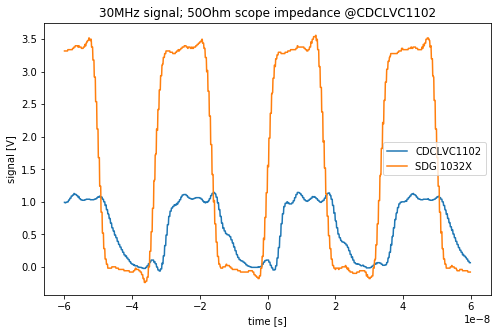

In [246]:
grp_name = 'REV1 Board Tests'
sub_grp_name = '50Ohm termination'

with h5py.File(fname, 'r') as f:
    grp = f[grp_name]
    grp = grp[sub_grp_name]
    grp = grp['30MHz']
    data = grp['measurement 100'].value


fig, ax= plt.subplots(figsize = (8,5))
ax.plot(data['time'], data[' CDCLVC1102_output'], label = 'CDCLVC1102')
ax.plot(data['time'], data[' SDG_1032X_output'], label = 'SDG 1032X')
ax.set_xlabel('time [s]')
ax.set_ylabel('signal [V]')
ax.set_title('30MHz signal; 50Ohm scope impedance @CDCLVC1102')
ax.legend()

In [229]:
sub_grp_name = '1MOhm termination'
create_hdf_subgrp(fname, grp_name, sub_grp_name, {'description': '1MOhm termination at scope'})

sdg = SDG1000X('USB0::0xF4EC::0x1103::SDG1XCAD2R3284::INSTR')
osc = RigolDS1054Z('USB0::0x1AB1::0x04CE::DS1ZA204619142::INSTR')

for freq in frequencies:
    description = f"CDCLVC REV1 circuit test with {freq}MHz, 0V to 3.3V, input from SDG 1032X\n"+\
                  "1MOhm termination @CH1 scope input (CDVLVC1102 output), 1MOhm termination @CH2 (SDG 1032X)"
    attrs = {'description': description, 'SDG 1032X frequency': f'{freq}MHz'}
    
    sdg.command(f'C1:BSWV FRQ,{freq}e6')   
    
    ssub_grp_name = f'{freq}MHz'
    create_hdf_ssubgrp(fname, grp_name, sub_grp_name, ssub_grp_name, attrs)
    
    for n in range(nsamples_per_freq):
        osc.command(':STOP')
        osc.command(':DISP:CLE')
        setup_scope_x(osc, 1/(freq*1e6)/5, 0)
        while True:
            osc.command(':SINGLE')
            
            try:
                while True:
                    if osc.query(':TRIG:STAT?') == 'STOP':
                        break
                data = scope_acquire(osc, [1,2])
                break
            except VisaIOerror:
                continue
        create_dset(fname, grp_name, sub_grp_name, ssub_grp_name, f'measurement {n+1}', data.T, cols, units)

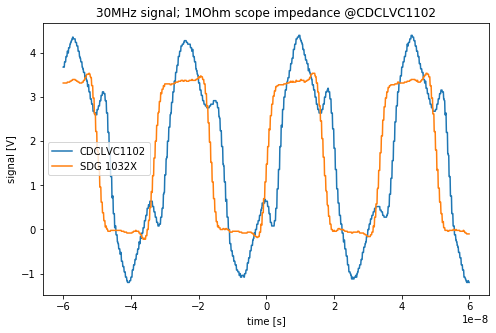

In [248]:
grp_name = 'REV1 Board Tests'
sub_grp_name = '1MOhm termination'

with h5py.File(fname, 'r') as f:
    grp = f[grp_name]
    grp = grp[sub_grp_name]
    grp = grp['30MHz']
    data = grp['measurement 100'].value


fig, ax= plt.subplots(figsize = (8,5))
ax.plot(data['time'], data[' CDCLVC1102_output'], label = 'CDCLVC1102')
ax.plot(data['time'], data[' SDG_1032X_output'], label = 'SDG 1032X')
ax.set_xlabel('time [s]')
ax.set_ylabel('signal [V]')
ax.set_title('30MHz signal; 1MOhm scope impedance @CDCLVC1102')
ax.legend()

## Board Revision 2
### Board 1

In [11]:
fname = 'CDCLVC1102_testing.hdf5'
nsamples_per_freq = 50
frequencies = np.array([1,5,10,15,20,25,30])

types = 'float, float, float'.split(',')
units = 's, V, V'.split(',')
units = [u.strip() for u in units]
cols = 'time, CDCLVC1102_output, SDG_1032X_output'.split(',')
cols = [c.strip() for c in cols]

osc = RigolDS1054Z('USB0::0x1AB1::0x04CE::DS1ZA204619142::INSTR')

setup_scope_y(osc, [1,2], ['DC']*2, [-1.6, -1.6], [1, 1])
setup_scope_x(osc, 10e-9, 0)
setup_scope_trigger(osc, 'CHAN2', 'DC', 'POS', 1.4)

grp_name = 'REV2 Board Tests'
create_hdf_grp(fname, grp_name, None)

In [12]:
sub_grp_name = '1MOhm termination'
create_hdf_subgrp(fname, grp_name, sub_grp_name, {'description': '1MOhm termination at scope'})

sdg = SDG1000X('USB0::0xF4EC::0x1103::SDG1XCAD2R3284::INSTR')
osc = RigolDS1054Z('USB0::0x1AB1::0x04CE::DS1ZA204619142::INSTR')

for freq in frequencies:
    description = f"CDCLVC REV2 circuit test with {freq}MHz, 0V to 3.3V, input from SDG 1032X\n"+\
                  "1MOhm termination @CH1 scope input (CDVLVC1102 output), 1MOhm termination @CH2 (SDG 1032X)"
    attrs = {'description': description, 'SDG 1032X frequency': f'{freq}MHz'}
    
    sdg.command(f'C1:BSWV FRQ,{freq}e6')   
    
    ssub_grp_name = f'{freq}MHz'
    create_hdf_ssubgrp(fname, grp_name, sub_grp_name, ssub_grp_name, attrs)
    
    for n in range(nsamples_per_freq):
        osc.command(':STOP')
        osc.command(':DISP:CLE')
        setup_scope_x(osc, 1/(freq*1e6)/5, 0)
        while True:
            osc.command(':SINGLE')
            
            try:
                while True:
                    if osc.query(':TRIG:STAT?') == 'STOP':
                        break
                data = scope_acquire(osc, [1,2])
                break
            except VisaIOerror:
                continue
        create_dset(fname, grp_name, sub_grp_name, ssub_grp_name, f'measurement {n+1}', data.T, cols, units)

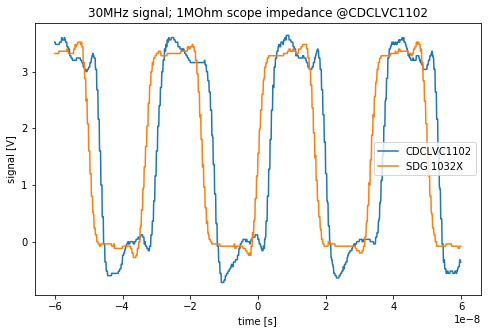

In [17]:
grp_name = 'REV2 Board Tests'
sub_grp_name = '1MOhm termination'

with h5py.File(fname, 'r') as f:
    grp = f[grp_name]
    grp = grp[sub_grp_name]
    grp = grp['30MHz']
    data = grp['measurement 50'].value


fig, ax= plt.subplots(figsize = (8,5))
ax.plot(data['time'], data['CDCLVC1102_output'], label = 'CDCLVC1102')
ax.plot(data['time'], data['SDG_1032X_output'], label = 'SDG 1032X')
ax.set_xlabel('time [s]')
ax.set_ylabel('signal [V]')
ax.set_title('30MHz signal; 1MOhm scope impedance @CDCLVC1102')
ax.legend()

### Board 2

In [25]:
fname = 'CDCLVC1102_testing.hdf5'
nsamples_per_freq = 50
frequencies = np.array([1,5,10,15,20,25,30])

types = 'float, float, float'.split(',')
units = 's, V, V'.split(',')
units = [u.strip() for u in units]
cols = 'time, CDCLVC1102_output, SDG_1032X_output'.split(',')
cols = [c.strip() for c in cols]

osc = RigolDS1054Z('USB0::0x1AB1::0x04CE::DS1ZA204619142::INSTR')

setup_scope_y(osc, [1,2], ['DC']*2, [-1.6, -1.6], [1, 1])
setup_scope_x(osc, 10e-9, 0)
setup_scope_trigger(osc, 'CHAN2', 'DC', 'POS', 1.4)

grp_name = 'REV2 Board 2 Tests'
create_hdf_grp(fname, grp_name, None)

In [26]:
sub_grp_name = '1MOhm termination'
create_hdf_subgrp(fname, grp_name, sub_grp_name, {'description': '1MOhm termination at scope'})

sdg = SDG1000X('USB0::0xF4EC::0x1103::SDG1XCAD2R3284::INSTR')
osc = RigolDS1054Z('USB0::0x1AB1::0x04CE::DS1ZA204619142::INSTR')

for freq in frequencies:
    description = f"CDCLVC REV2 circuit test with {freq}MHz, 0V to 3.3V, input from SDG 1032X\n"+\
                  "1MOhm termination @CH1 scope input (CDVLVC1102 output), 1MOhm termination @CH2 (SDG 1032X)"
    attrs = {'description': description, 'SDG 1032X frequency': f'{freq}MHz'}
    
    sdg.command(f'C1:BSWV FRQ,{freq}e6')   
    
    ssub_grp_name = f'{freq}MHz'
    create_hdf_ssubgrp(fname, grp_name, sub_grp_name, ssub_grp_name, attrs)
    
    for n in range(nsamples_per_freq):
        osc.command(':STOP')
        osc.command(':DISP:CLE')
        setup_scope_x(osc, 1/(freq*1e6)/5, 0)
        while True:
            osc.command(':SINGLE')
            
            try:
                while True:
                    if osc.query(':TRIG:STAT?') == 'STOP':
                        break
                data = scope_acquire(osc, [1,2])
                break
            except VisaIOerror:
                continue
        create_dset(fname, grp_name, sub_grp_name, ssub_grp_name, f'measurement {n+1}', data.T, cols, units)

In [10]:
fname = 'CDCLVC1102_testing.hdf5'
nsamples_per_freq = 50
frequencies = np.array([1,5,10,15,20,25,30])

types = 'float, float, float'.split(',')
units = 's, V, V'.split(',')
units = [u.strip() for u in units]
cols = 'time, CDCLVC1102_output, SDG_1032X_output'.split(',')
cols = [c.strip() for c in cols]

osc = RigolDS1054Z('USB0::0x1AB1::0x04CE::DS1ZA204619142::INSTR')

setup_scope_y(osc, [1,2], ['DC']*2, [-1.6, -1.6], [1, 1])
setup_scope_x(osc, 10e-9, 0)
setup_scope_trigger(osc, 'CHAN2', 'DC', 'POS', 1.4)

grp_name = 'REV2 Board 3 Tests'
# create_hdf_grp(fname, grp_name, None)

In [11]:
sub_grp_name = '1MOhm termination'
create_hdf_subgrp(fname, grp_name, sub_grp_name, {'description': '1MOhm termination at scope'})

sdg = SDG1000X('USB0::0xF4EC::0x1103::SDG1XCAD2R3284::INSTR')
osc = RigolDS1054Z('USB0::0x1AB1::0x04CE::DS1ZA204619142::INSTR')

for freq in frequencies:
    description = f"CDCLVC REV2 circuit test with {freq}MHz, 0V to 3.3V, input from SDG 1032X\n"+\
                  "1MOhm termination @CH1 scope input (CDVLVC1102 output), 1MOhm termination @CH2 (SDG 1032X)"
    attrs = {'description': description, 'SDG 1032X frequency': f'{freq}MHz'}
    
    sdg.command(f'C1:BSWV FRQ,{freq}e6')   
    
    ssub_grp_name = f'{freq}MHz'
    create_hdf_ssubgrp(fname, grp_name, sub_grp_name, ssub_grp_name, attrs)
    
    for n in range(nsamples_per_freq):
        osc.command(':STOP')
        osc.command(':DISP:CLE')
        setup_scope_x(osc, 1/(freq*1e6)/5, 0)
        while True:
            osc.command(':SINGLE')
            
            try:
                while True:
                    if osc.query(':TRIG:STAT?') == 'STOP':
                        break
                data = scope_acquire(osc, [1,2])
                break
            except VisaIOerror:
                continue
        create_dset(fname, grp_name, sub_grp_name, ssub_grp_name, f'measurement {n+1}', data.T, cols, units)

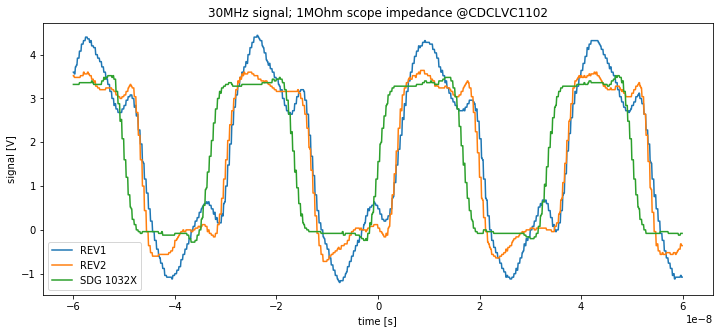

In [23]:
grp_name = 'REV1 Board Tests'
sub_grp_name = '1MOhm termination'

with h5py.File(fname, 'r') as f:
    grp = f[grp_name]
    grp = grp[sub_grp_name]
    grp = grp['30MHz']
    data_rev1 = grp['measurement 50'].value
    
grp_name = 'REV2 Board Tests'
sub_grp_name = '1MOhm termination'

with h5py.File(fname, 'r') as f:
    grp = f[grp_name]
    grp = grp[sub_grp_name]
    grp = grp['30MHz']
    data_rev2 = grp['measurement 50'].value


fig, ax= plt.subplots(figsize = (12,5))
ax.plot(data_rev1['time'], data_rev1[' CDCLVC1102_output'], label = 'REV1')
ax.plot(data_rev2['time'], data_rev2['CDCLVC1102_output'], label = 'REV2')
ax.plot(data_rev2['time'], data_rev2['SDG_1032X_output'], label = 'SDG 1032X')
ax.set_xlabel('time [s]')
ax.set_ylabel('signal [V]')
ax.set_title('30MHz signal; 1MOhm scope impedance @CDCLVC1102')
ax.legend()

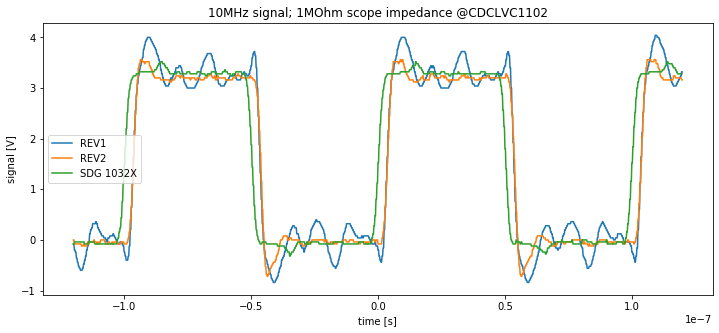

In [24]:
grp_name = 'REV1 Board Tests'
sub_grp_name = '1MOhm termination'

with h5py.File(fname, 'r') as f:
    grp = f[grp_name]
    grp = grp[sub_grp_name]
    grp = grp['10MHz']
    data_rev1 = grp['measurement 50'].value
    
grp_name = 'REV2 Board Tests'
sub_grp_name = '1MOhm termination'

with h5py.File(fname, 'r') as f:
    grp = f[grp_name]
    grp = grp[sub_grp_name]
    grp = grp['10MHz']
    data_rev2 = grp['measurement 50'].value


fig, ax= plt.subplots(figsize = (12,5))
ax.plot(data_rev1['time'], data_rev1[' CDCLVC1102_output'], label = 'REV1')
ax.plot(data_rev2['time'], data_rev2['CDCLVC1102_output'], label = 'REV2')
ax.plot(data_rev2['time'], data_rev2['SDG_1032X_output'], label = 'SDG 1032X')
ax.set_xlabel('time [s]')
ax.set_ylabel('signal [V]')
ax.set_title('10MHz signal; 1MOhm scope impedance @CDCLVC1102')
ax.legend()

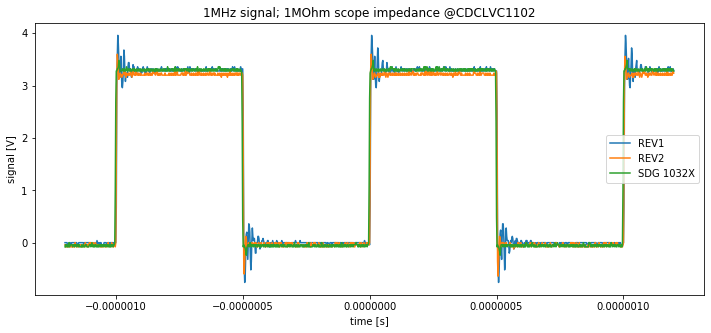

In [25]:
grp_name = 'REV1 Board Tests'
sub_grp_name = '1MOhm termination'

with h5py.File(fname, 'r') as f:
    grp = f[grp_name]
    grp = grp[sub_grp_name]
    grp = grp['1MHz']
    data_rev1 = grp['measurement 50'].value
    
grp_name = 'REV2 Board Tests'
sub_grp_name = '1MOhm termination'

with h5py.File(fname, 'r') as f:
    grp = f[grp_name]
    grp = grp[sub_grp_name]
    grp = grp['1MHz']
    data_rev2 = grp['measurement 50'].value


fig, ax= plt.subplots(figsize = (12,5))
ax.plot(data_rev1['time'], data_rev1[' CDCLVC1102_output'], label = 'REV1')
ax.plot(data_rev2['time'], data_rev2['CDCLVC1102_output'], label = 'REV2')
ax.plot(data_rev2['time'], data_rev2['SDG_1032X_output'], label = 'SDG 1032X')
ax.set_xlabel('time [s]')
ax.set_ylabel('signal [V]')
ax.set_title('1MHz signal; 1MOhm scope impedance @CDCLVC1102')
ax.legend()

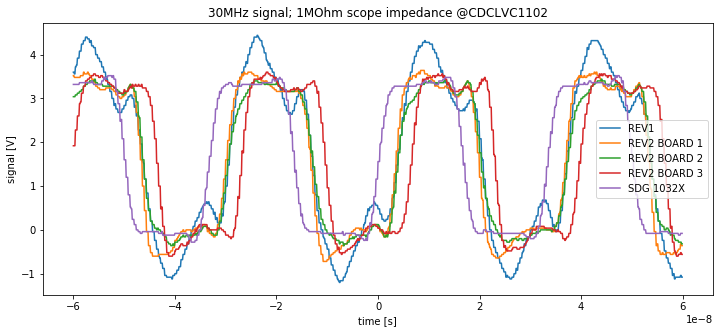

In [29]:
grp_name = 'REV1 Board Tests'
sub_grp_name = '1MOhm termination'

with h5py.File(fname, 'r') as f:
    grp = f[grp_name]
    grp = grp[sub_grp_name]
    grp = grp['30MHz']
    data_rev1 = grp['measurement 50'].value
    
grp_name = 'REV2 Board Tests'
sub_grp_name = '1MOhm termination'

with h5py.File(fname, 'r') as f:
    grp = f[grp_name]
    grp = grp[sub_grp_name]
    grp = grp['30MHz']
    data_rev2 = grp['measurement 50'].value

grp_name = 'REV2 Board 2 Tests'
sub_grp_name = '1MOhm termination'

with h5py.File(fname, 'r') as f:
    grp = f[grp_name]
    grp = grp[sub_grp_name]
    grp = grp['30MHz']
    data_rev2_2 = grp['measurement 50'].value

grp_name = 'REV2 Board 3 Tests'
sub_grp_name = '1MOhm termination'

with h5py.File(fname, 'r') as f:
    grp = f[grp_name]
    grp = grp[sub_grp_name]
    grp = grp['30MHz']
    data_rev2_3 = grp['measurement 50'].value
    
fig, ax= plt.subplots(figsize = (12,5))
ax.plot(data_rev1['time'], data_rev1[' CDCLVC1102_output'], label = 'REV1')
ax.plot(data_rev2['time'], data_rev2['CDCLVC1102_output'], label = 'REV2 BOARD 1')
ax.plot(data_rev2_2['time'], data_rev2_2['CDCLVC1102_output'], label = 'REV2 BOARD 2')
ax.plot(data_rev2_3['time'], data_rev2_3['CDCLVC1102_output'], label = 'REV2 BOARD 3')
ax.plot(data_rev2['time'], data_rev2['SDG_1032X_output'], label = 'SDG 1032X')
ax.set_xlabel('time [s]')
ax.set_ylabel('signal [V]')
ax.set_title('30MHz signal; 1MOhm scope impedance @CDCLVC1102')
ax.legend()

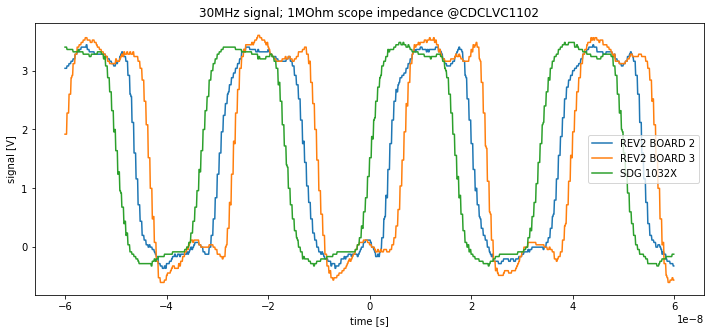

In [32]:
fig, ax= plt.subplots(figsize = (12,5))
ax.plot(data_rev2_2['time'], data_rev2_2['CDCLVC1102_output'], label = 'REV2 BOARD 2')
ax.plot(data_rev2_3['time'], data_rev2_3['CDCLVC1102_output'], label = 'REV2 BOARD 3')
ax.plot(data_rev2_3['time'], data_rev2_3['SDG_1032X_output'], label = 'SDG 1032X')
ax.set_xlabel('time [s]')
ax.set_ylabel('signal [V]')
ax.set_title('30MHz signal; 1MOhm scope impedance @CDCLVC1102')
ax.legend()